In [13]:
import os
import numpy as np
from PIL import Image
import PIL.ImageOps    
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import image_registration
from astropy.nddata import Cutout2D
from astropy import units as u
import matplotlib.image as mpimg

from __future__ import print_function
#import cv2
import numpy as np

from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry

from astropy.stats import sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

 
import pandas as pd
import pandasql as ps
plt.style.use(astropy_mpl_style)

from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion

In [2]:
def makeFits(inName,imageExtension='.jpg'):
    image = Image.open(inName)
    xsize, ysize = image.size
    print("Image size: {} x {}".format(xsize, ysize))
    # plt.imshow(image)

    r, g, b = image.split()
    r_data = np.array(r.getdata()) # data is now an array of length ysize*xsize
    g_data = np.array(g.getdata())
    b_data = np.array(b.getdata())
    print(r_data.shape)

    r_data = r_data.reshape(ysize, xsize)[::-1]
    g_data = g_data.reshape(ysize, xsize)[::-1]
    b_data = b_data.reshape(ysize, xsize)[::-1]

    inName = inName.replace(imageExtension,'')
    print(inName)
    try:
        os.remove(inName+"red.fits")
        os.remove(inName+"green.fits")
        os.remove(inName+"blue.fits")
    except:
        print("Can't remove as the file doesn't exist")

    red = fits.PrimaryHDU(r_data)
    hdur = fits.HDUList([red])
    hdur.writeto(inName+'red.fits')
    
    green = fits.PrimaryHDU(g_data)
    hdug = fits.HDUList([green])
    hdug.writeto(inName+'green.fits')

    blue = fits.PrimaryHDU(b_data)
    hdub = fits.HDUList([blue])
    hdub.writeto(inName+'blue.fits')

In [3]:
def daoStarFinder(imagename,FWHM=50,thresh=3.):
    """
    Locates and measures the brightness of all objects in the image as well as the sky background
    and other image data.

    :param imagenumber: Position of image in directory
    :return: Table of object data, date of observation, image data for backround calculation
    """
    #print(Image[imagenumber])
    hdu_list = fits.open(imagename) # open image header
    imagedata = (hdu_list[0].data) 
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
    imagedata[imagedata < 0.75*mean] = 0
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
#     Median.append(median)
#     STD.append(std)
    print(mean,median,std)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=thresh*std) # iraf star finder 
    Sources = daofind(imagedata - median)
    #Date = (hdu_list[0].header['MJD'])
    output = {}
    output[0] = Sources
#     output[1] = Date
#     output[2] = imagedata
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10, 10))
    positions = (output[0]['xcentroid'], output[0]['ycentroid'])
    apertures = CircularAperture(positions, r=10.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
    apertures.plot(color='black', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    ax2.imshow(imagedata, cmap='Greys', origin='lower')
    plt.show()
    
    
    
#     os.chdir(bindingsdirectory)
#     astroprov.provcall([imagenumber],[output[0],output[1],output[2]],"daoStarFinder_PythonCode2Images_SQ_tmpl.provn","daoStarFinder")
#     os.chdir(imagedirectory)
    return output




In [4]:
def assessQuality(output,sqlQuery,refPandasNew):
    pandasTable = Table.to_pandas(output[0])
    newdf = ps.sqldf(sqlQuery,locals())
    if len(newdf) != 0:
        completeness = float(len(newdf))/float(len(refPandasNew))
        accuracy = float(len(newdf))/float(len(pandasTable))
    else:
        print('no objects found')
        completeness = 0
        accuracy = 0
    total = completeness + accuracy
    return [completeness,accuracy,total]

In [5]:
def ds9File2Lists(fileName):
    with open(fileName,'r') as f:
        data = f.readlines()

    ycoord = []
    xcoord = []
    radius = []
    starLocations = []
    for x in data[:-1]:
        locator1 = '('
        locator2 = ','
        locator3 = ')'
        loc1 = x.index(locator1) +1
        #print(x)
        loc2 = x[loc1:].index(locator2) + loc1 +1
        loc3 = x[loc2:].index(locator2) + loc2
        loc4 = x.index(locator3)
        xcoord.append(float(x[loc1:loc2-1]))
        ycoord.append(float(x[loc2:loc3]))
        radius.append(float(x[loc3+1:loc4]))
    return [xcoord,ycoord,radius]

In [6]:
def matchTables(table1,table2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.xcentroid < pandasTable2.xUpper
    AND pandasTable1.xcentroid > pandasTable2.xLower
    AND pandasTable1.ycentroid < pandasTable2.yUpper
    AND pandasTable1.ycentroid > pandasTable2.yLower
    '''
    pandasTable1 = Table.to_pandas(table1)
    
    xcoord = table2['xcentroid']
    ycoord = table2['ycentroid']
    flux = table2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [7]:
def matchTables2(table1,table2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.xcentroid < pandasTable2.xUpper2
    AND pandasTable1.xcentroid > pandasTable2.xLower2
    AND pandasTable1.ycentroid < pandasTable2.yUpper2
    AND pandasTable1.ycentroid > pandasTable2.yLower2
    '''
    pandasTable1 = Table.to_pandas(table1)
    
    xcoord = table2['xcentroid']
    ycoord = table2['ycentroid']
    flux = table2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'index2':range(len(xcoord)),'xcoord2':xcoord,'ycoord2':ycoord,'xUpper2':xUpper,'xLower2':xLower,
              'yUpper2':yUpper,'yLower2':yLower,'fluxMatch2':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [8]:
def findAndRefine(image,fwhm=20,thr=3):
    imShort = image[:image.index('.jpg')]
    
    imagedata = Image.open(image)
    inverted_image = PIL.ImageOps.invert(imagedata)
    inverted_image.save(imShort+'Inverted.jpg')
    makeFits(imShort+'Inverted.jpg')
    imGreen,imBlue,imRed = imShort+'Invertedgreen.fits',imShort+'Invertedblue.fits',imShort+'Invertedred.fits'
    
    outputAlignBlue = daoStarFinder(imBlue,FWHM=fwhm,thresh=thr)
    outputAlignRed = daoStarFinder(imRed,FWHM=fwhm,thresh=thr)
    outputAlignGreen = daoStarFinder(imGreen,FWHM=fwhm,thresh=thr)
    
    matchedObjects = matchTables(outputAlignBlue[0],outputAlignGreen[0])
    matchedObjects2 = matchTables2(Table.from_pandas(matchedObjects),outputAlignRed[0])
    
    matchedObjects = matchedObjects2
    
#     fluxRatio = [x/y for x,y in zip(matchedObjects['flux'].tolist(),matchedObjects['fluxMatch'].tolist())]
    
#     dropRows = []
#     medianFlux = np.median(fluxRatio)
#     stdFlux = np.std(fluxRatio)
#     print(len(fluxRatio))

#     for i,x in enumerate(fluxRatio):
#         if x > medianFlux + (stdFlux):
#             dropRows.append(i)
#         if x < medianFlux - (stdFlux):
#             dropRows.append(i)

    matchedRefined = matchedObjects #.drop(dropRows)
#     matchedRefined.sort_values(by=['flux'])
#     matchedRefined = matchedRefined[0:25]
    
    hdu_list = fits.open(imGreen)
    imagedata = hdu_list[0].data
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10, 10))
    positions = (matchedRefined['xcentroid'].tolist(), matchedRefined['ycentroid'].tolist())
    apertures = CircularAperture(positions, r=10.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
    apertures.plot(color='black', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    ax2.imshow(imagedata, cmap='Greys', origin='lower')
    plt.show()
    
    return matchedRefined

In [9]:
def getImageData(imageName,extension):
    hdu = fits.open(imageName)
    imageData = hdu[extension].data
    return imageData

In [10]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [ ]:
def plotMolesAndMask(image,moleLocFile):
    imdata = getImageData(image)
    moleLocs = ds9File2Lists(moleLocFile)
    imageShape = imdata.shape


In [11]:
alignlocs = ds9File2Lists('./79948blueMolePositions.txt')
reflocs = ds9File2Lists('./29018blueMolePositions.txt')

In [14]:
imdata = getImageData('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits',0)

In [18]:
# clunky masking for testing, change later

imageShape = imdata.shape
image = []
for x in range(len(alignlocs[0])):
    highx = alignlocs[0][x] + alignlocs[2][x]
    lowx = alignlocs[0][x] - alignlocs[2][x]
    
    highy = alignlocs[1][x] + alignlocs[2][x]
    lowy = alignlocs[1][x] - alignlocs[2][x]
    
    
    for y in range(imageShape[0]):
        x = [1 if highx > y > lowx and highy > z > lowy else 0 for z,val in enumerate(range(imageShape[1]))]
        image.append(x)

In [19]:
mask = []
for mole in range(len(alignlocs[0])):
    centre = PixCoord(alignlocs[0][mole],alignlocs[1][mole])
    reg = CirclePixelRegion(centre,alignlocs[2][mole])
    mask.append(reg.to_mask())


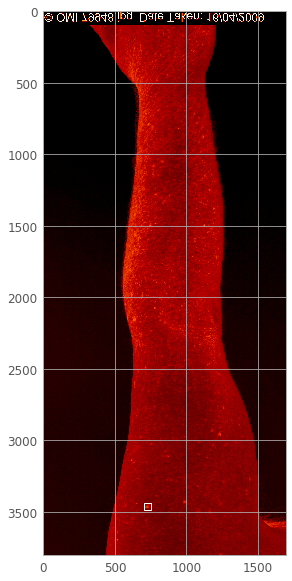

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(imdata)
ax.add_artist(mask[0].bbox.as_artist(facecolor='none', edgecolor='white'))
plt.show()

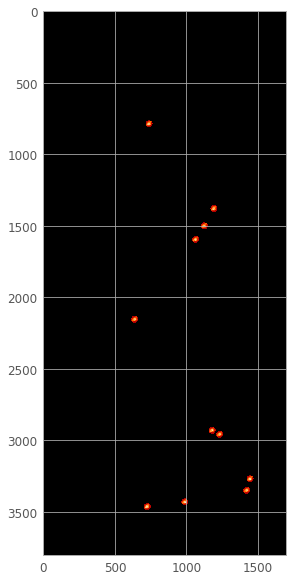

In [131]:
zeros = np.zeros(imdata.shape)
maskData = []
for m in mask:
    maskData.append(m.cutout(imdata)*m.data)
    
for x in range(len(maskData)):
    zeros[int(alignlocs[1][x])-25:int(alignlocs[1][x])+25,int(alignlocs[0][x])-25:int(alignlocs[0][x])+25] = data

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(zeros)

#newax = fig.add_axes(rect,anchor='NE')
#newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE', zorder=-1)

#newax.imshow(data)
#ax.add_artist(mask[0].bbox.as_artist(facecolor='none', edgecolor='white'))
plt.show()

In [126]:
zeros = np.zeros(imdata.shape)
zeros[int(alignlocs[1][0])-25:int(alignlocs[1][0])+25,int(alignlocs[0][0])-25:int(alignlocs[0][0])+25] = data
print(zeros.shape)

(3800, 1694)


In [127]:
print(alignlocs[0][0],alignlocs[1][0])

726.90669 3462.4934


In [128]:
zeros[int(alignlocs[1][0])-25:int(alignlocs[1][0])+25,int(alignlocs[0][0])-25:int(alignlocs[0][0])+25] = data

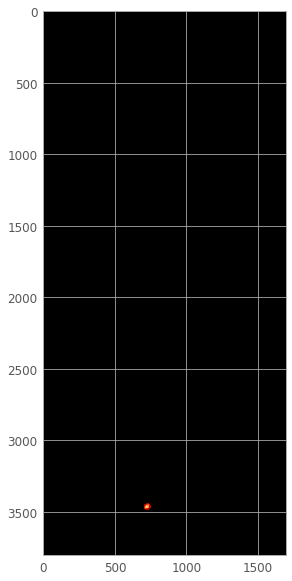

In [129]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(zeros)

#newax = fig.add_axes(rect,anchor='NE')
#newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE', zorder=-1)

#newax.imshow(data)
#ax.add_artist(mask[0].bbox.as_artist(facecolor='none', edgecolor='white'))
plt.show()

In [116]:
print(alignlocs[0][0],alignlocs[1][0])

726.90669 3462.4934


In [117]:
zeros[int(alignlocs[0][1])-25:int(alignlocs[0][1])+25,int(alignlocs[0][0])-25:int(alignlocs[0][0])+25].shape

(50, 50)

In [120]:
zeros[int(alignlocs[0][0])-25:int(alignlocs[0][0])+25,int(alignlocs[0][1])-25:int(alignlocs[0][1])+25] = data

In [31]:
print(alignlocs[0][0],alignlocs[1][0])

726.90669 3462.4934


In [33]:
print(data.shape)
print(imdata.shape)

(50, 50)
(3800, 1694)


In [51]:
maskShape = data.shape
imageShape = imdata.shape
print(maskShape[0])

50


In [85]:
1694./3800.

0.4457894736842105

In [90]:
rect = [(alignlocs[1][0]-(maskShape[0]/2))/imageShape[0],(alignlocs[0][1]-(maskShape[1]/2))/imageShape[1],float((maskShape[0]))/float(imageShape[0]),float((maskShape[1]))/float(imageShape[1])]

In [91]:
print(rect)

[0.9046035263157894, 0.5693994628099174, 0.013157894736842105, 0.0295159386068477]


In [65]:
rect = [ 0.5693994628099174, 0.9046035263157894, 0.0295159386068477,0.013157894736842105]

In [100]:
rect = [0.1,0.1,0.05,0.05]

In [71]:
fig.add_axes?

In [ ]:
figsize=(3.841, 7.195), dpi=100

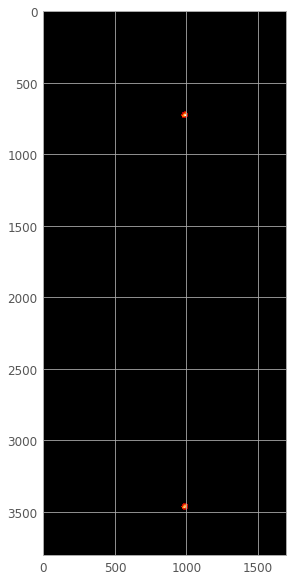

In [121]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(zeros)

#newax = fig.add_axes(rect,anchor='NE')
#newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE', zorder=-1)

#newax.imshow(data)
#ax.add_artist(mask[0].bbox.as_artist(facecolor='none', edgecolor='white'))
plt.show()

In [94]:
print(len(zeros[0]))
region1 = mask[0][]

1694


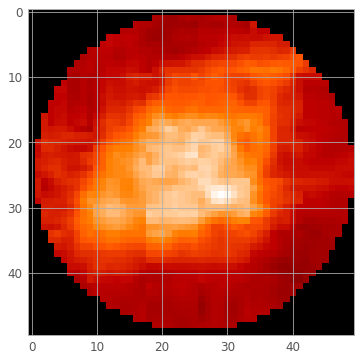

In [23]:
plt.imshow(data)
plt.show()

In [13]:
imageRefernce = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
imageAlign =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

In [15]:
alignedHDU = alignImages(hdu_list)

Image size: 1190 x 3800
(4522000,)
/home/mj1e16/moleGazer/Photos/F/29018Inverted
66.90609213343083 89.0 54.582023222885155


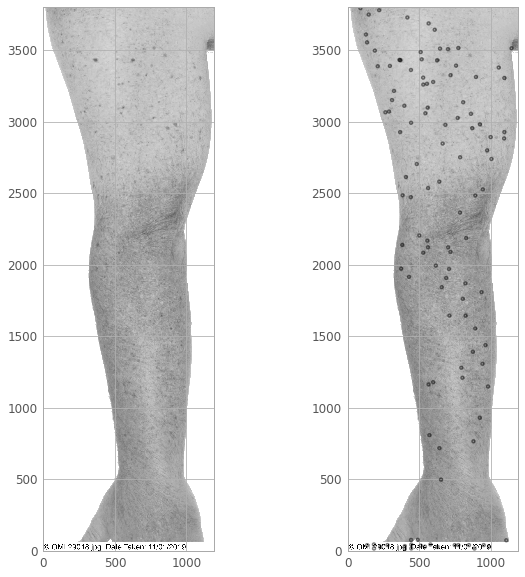

39.340150160965905 51.0 32.74172185653438


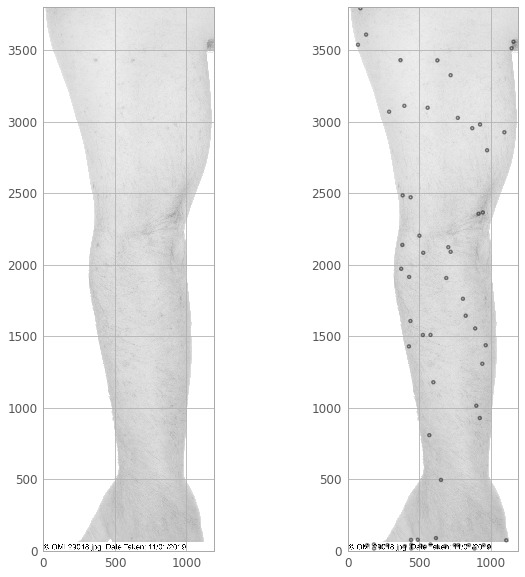

60.60381469095775 85.0 48.90740743315526


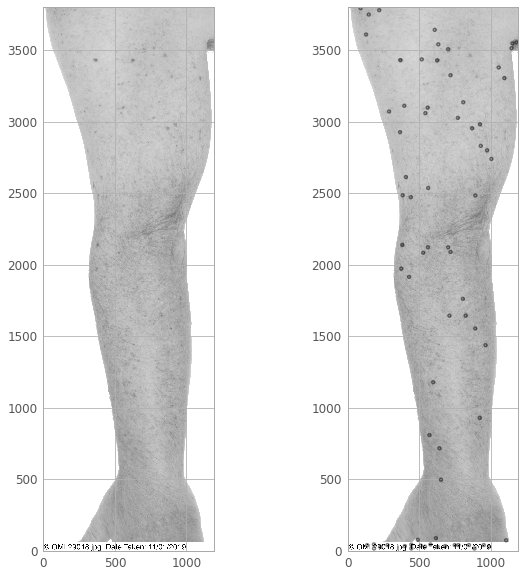

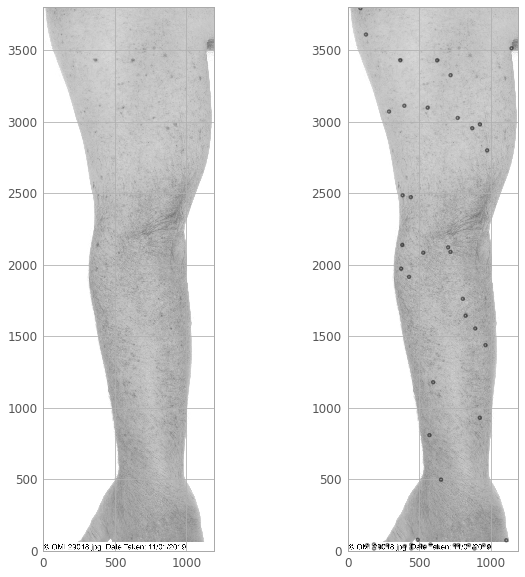

In [40]:
matchedObjects = findAndRefine(imageRefernce)

Image size: 1694 x 3800
(6437200,)
/home/mj1e16/moleGazer/Photos/F/79948Inverted
43.595306625182324 0.0 51.36032811380945


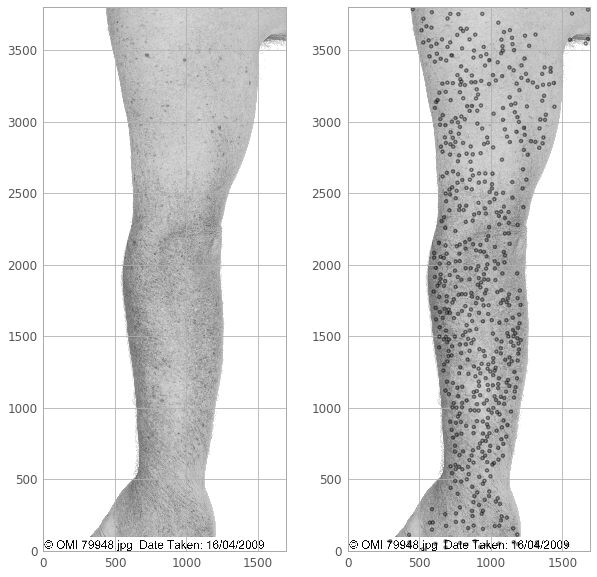

23.319864956995517 0.0 28.110202583683904


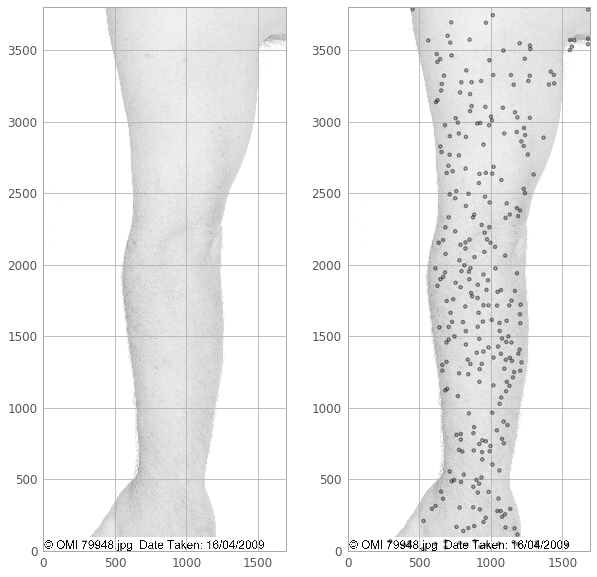

37.688935010539225 0.0 44.16477174977314


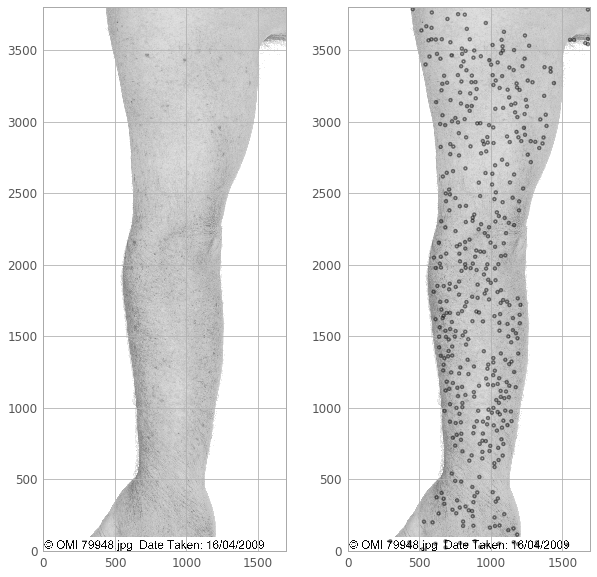

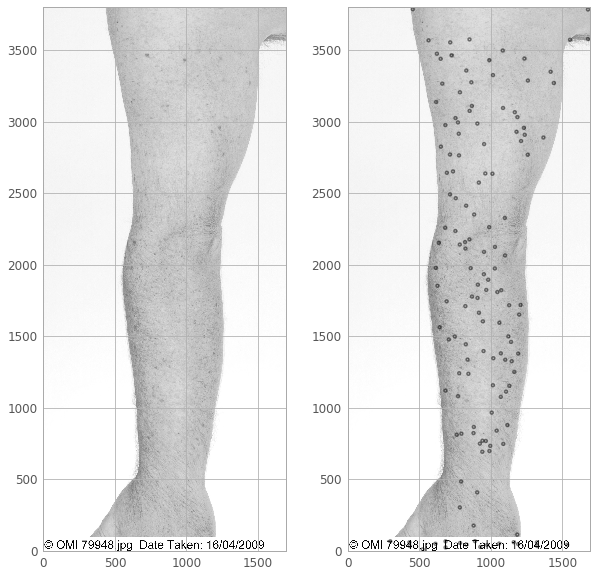

In [42]:
matchedObjects = findAndRefine(imageAlign,fwhm=30,thr=2)